In [1]:
from deform_dataloader import CustomDataset
import gc
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

data = CustomDataset("C:/Users/arpit/Desktop/M005_front")

VALID_SIZE = 0.2
BATCH_SIZE = 1
SEED = 0

np.random.seed(SEED)
device = 'cuda'

len(data)

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4726

### Training

In [ ]:
'''
test_vids = ['happy_level_3_014', 'happy_level_2_005', 'happy_level_1_029',
       'happy_level_1_009', 'happy_level_1_028', 'happy_level_3_008',
       'neutral_level_1_024', 'neutral_level_1_026',
       'neutral_level_1_001', 'happy_level_2_002', 'happy_level_3_027',
       'neutral_level_1_023', 'neutral_level_1_016']

train_valid_indices = [idx for idx, v in enumerate(data.videos) if v not in test_vids]
train_valid_vids = [v for v in data.videos if v not in test_vids]
len(train_valid_vids)
'''

4157

In [3]:
len(set(data.videos))

40

In [5]:
# generate indices: instead of the actual data we pass in integers instead
train_indices, valid_indices, _, _ = train_test_split(
    range(len(data)),
    data.videos,
    stratify=data.videos,
    test_size=0.01,  #VALID_SIZE,   ## ONLY FOR TESTING
    train_size=0.01,  ## ONLY FOR TESTING
    random_state=SEED
)

len(train_indices), len(valid_indices)

(47, 48)

In [6]:
# generate subset based on indices
train_split = Subset(data, train_indices) 
valid_split = Subset(data, valid_indices) 

# create batches
train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
valid_batches = DataLoader(valid_split, batch_size=BATCH_SIZE)

len(valid_batches), len(train_batches)

(48, 47)

In [5]:
# load gaussians

from scene import GaussianModel, Scene
from gaussian_renderer import render_motion
from arguments import PipelineParams
from arguments import ModelParams
from argparse import ArgumentParser
import sys
import torch

gpath = "C:/Users/arpit/Downloads/M005/M005"
colmap_path = "C:/Users/arpit/Desktop/gs_data/all_videos/M005"
sys.argv = f"x --source_path {colmap_path} -r 2".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])


temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

front_cam = [cam for cam in scene.getTrainCameras() if cam.image_name.startswith('front')]

pipe = PipelineParams(parser)

gaussians.load_ply("C:/Users/arpit/Desktop/M005_no_densify/point_cloud/iteration_30000/point_cloud.ply")

Reading camera 7/7
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  4085


In [ ]:
"""
front_cam[0].alpha_mask = front_cam[0].alpha_mask.half()
front_cam[0].original_image = front_cam[0].original_image.half()
front_cam[0].world_view_transform = front_cam[0].world_view_transform.half()
front_cam[0].full_proj_transform = front_cam[0].full_proj_transform.half()
front_cam[0].camera_center = front_cam[0].camera_center.half()
front_cam[0].projection_matrix = front_cam[0].projection_matrix.half()

gaussians._xyz = gaussians._xyz.half()
gaussians._features_dc = gaussians._features_dc.half()
gaussians._features_rest = gaussians._features_rest.half()
gaussians._scaling = gaussians._scaling.half()
gaussians._rotation = gaussians._rotation.half()
gaussians._opacity = gaussians._opacity.half()
gaussians.max_radii2D = gaussians.max_radii2D.half()
gaussians.xyz_gradient_accum = gaussians.xyz_gradient_accum.half()
gaussians.denom = gaussians.denom.half()
gaussians._exposure = gaussians._exposure.half()
"""

In [7]:
import gc
gc.collect()

63

In [8]:
from utils.loss_utils import l1_loss, ssim
from utils.image_utils import psnr
from deform_net import MLP_Less_Params
from lpipsPyTorch import lpips

model = MLP_Less_Params(n_gaussians=4085, n_features=11, aud_in=1707, emo_in=1280).to(device)

In [9]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
'''
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=0.1)
        nn.init.zeros_(m.bias)

model.apply(init_weights)
'''

'\nimport torch.nn as nn\n\ndef init_weights(m):\n    if isinstance(m, nn.Linear):\n        nn.init.xavier_uniform_(m.weight, gain=0.1)\n        nn.init.zeros_(m.bias)\n\nmodel.apply(init_weights)\n'

In [10]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))


model size: 1474.497MB


In [11]:
gaussians._features_dc.requires_grad = False
gaussians._features_rest.requires_grad = False
gaussians._xyz.requires_grad = False
gaussians._rotation.requires_grad = False
gaussians._scaling.requires_grad = False
gaussians._opacity.requires_grad = False

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

scheduler = ExponentialLR(opt, gamma=0.95)

In [13]:
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
simulated_batch_size = 2

use_amp=True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

In [14]:
from lpipsPyTorch.modules.lpips import LPIPS

lpips_obj = LPIPS(net_type='vgg').to(device)

In [15]:
%%time

for epoch in range(1):
    losses = []
    #train_lpips = []
    model.train()
    loss_opt = torch.Tensor([0]).to(device)
    for batch_num, input_data in enumerate(train_batches):

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            gt_image, aud, emo, _ = input_data
            gt_image = gt_image[0].to(device)
            aud = aud.to(device)
            emo = emo.to(device)
            
            output = model(aud, emo)

            #output = 
            scaler.scale(output)

            print(output.dtype)
            
            output_image = render_motion(front_cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(4085, -1),
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp, 
                   )["render"]
            
            Ll1 = l1_loss(output_image, gt_image)
            ssim_value = ssim(output_image, gt_image)
            lpips_value = lpips_obj(output_image, gt_image)#.item()
            loss = 0.8 * Ll1 + 0.2 * (1.0 - ssim_value) + 0.1 * lpips_value
            loss_opt = loss_opt + loss 
            losses.append(loss.item())
            
            if (batch_num > 0) and (batch_num % simulated_batch_size) == 0:
                scaler.scale(loss_opt).backward()
                scaler.step(opt)
                scaler.update()
                print('\tEpoch %d | Batch %d | Loss %6.3f' % (epoch, batch_num, torch.sum(loss_opt)/simulated_batch_size))
                opt.zero_grad()
                loss_opt = torch.Tensor([0]).to(device)
                torch.cuda.empty_cache()
            
    if loss_opt.item() != 0:
        scaler.scale(loss_opt).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()    
    
    v_losses = []
    v_psnrs = []
    #v_lpips = []
    model.eval()
    with torch.no_grad():
        for batch_num, input_data in enumerate(valid_batches):
            
            with torch.autocast(device_type=device, dtype=torch.float16):
                gt_image, aud, emo, _ = input_data
                gt_image = gt_image[0].to(device)
                aud = aud.to(device)
                emo = emo.to(device)
                
                output = model(aud, emo)
                
                output_image = render_motion(front_cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(4085, -1),
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp, 
                )["render"]
                
                Ll1 = l1_loss(output_image, gt_image)
                ssim_value = ssim(output_image, gt_image)
                lpips_value = lpips_obj(output_image, gt_image)#.item()
                loss = 0.8 * Ll1 + 0.2 * (1.0 - ssim_value) + 0.1 * lpips_value
                v_losses.append(loss.item())
                v_psnr = psnr(output_image, gt_image).mean().double()
                v_psnrs.append(v_psnr.item())
                #v_lpips.append(lpips_value)
    
    scheduler.step()
        
    print(
        'Epoch %d | Train Loss %6.3f | Val Loss %6.3f | Val PSNR %6.3f' % 
        (epoch, sum(losses)/len(losses), sum(v_losses)/len(v_losses), sum(v_psnrs)/len(v_psnrs))
    )

torch.float16
torch.float16
torch.float16
	Epoch 0 | Batch 2 | Loss -0.025
torch.float16
torch.float16
	Epoch 0 | Batch 4 | Loss -0.014
torch.float16
torch.float16


KeyboardInterrupt: 

In [16]:
output.dtype

torch.float16

In [3]:
import torch

type(torch.Tensor)

torch._C._TensorMeta

In [15]:
psnr(output_image, gt_image)

tensor([[27.0839],
        [28.8789],
        [29.2053]], device='cuda:0')

In [14]:
output_image.shape

torch.Size([3, 540, 960])

In [16]:
import gc
gc.collect()

21

In [16]:
torch.min(output_image), torch.max(output_image)

(tensor(0., device='cuda:0'), tensor(0.8752, device='cuda:0'))

In [17]:
torch.min(gt_image), torch.max(gt_image)

(tensor(0., device='cuda:0'), tensor(0.9961, device='cuda:0'))

In [18]:
ssim(output_image, gt_image)

tensor(0.9272, device='cuda:0')

In [19]:
lpips(output_image, gt_image).item()

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.06891312450170517

(array([1.27426e+06, 1.39930e+05, 9.15910e+04, 2.86070e+04, 1.24630e+04,
        5.96700e+03, 1.91800e+03, 3.89000e+02, 3.50000e+01, 4.00000e+01]),
 array([0.        , 0.09960784, 0.19921568, 0.29882354, 0.39843136,
        0.49803922, 0.5976471 , 0.6972549 , 0.7968627 , 0.8964706 ,
        0.99607843], dtype=float32),
 <BarContainer object of 10 artists>)

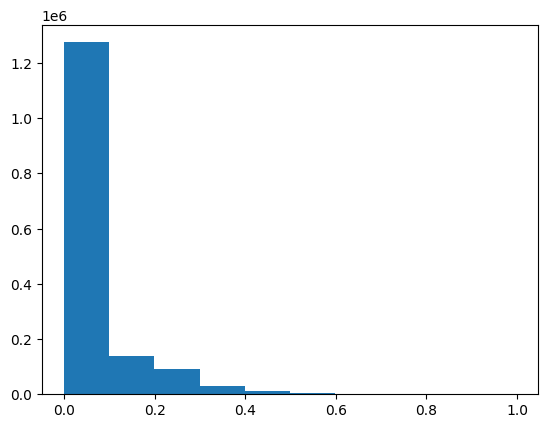

In [20]:
import matplotlib.pyplot as plt

plt.hist(gt_image.flatten().cpu().detach().numpy())

(array([1.245639e+06, 1.157540e+05, 1.195090e+05, 4.393300e+04,
        1.464900e+04, 1.010000e+04, 4.680000e+03, 8.660000e+02,
        6.600000e+01, 4.000000e+00]),
 array([0.        , 0.08751742, 0.17503484, 0.26255226, 0.35006967,
        0.43758708, 0.5251045 , 0.6126219 , 0.70013934, 0.7876567 ,
        0.87517416], dtype=float32),
 <BarContainer object of 10 artists>)

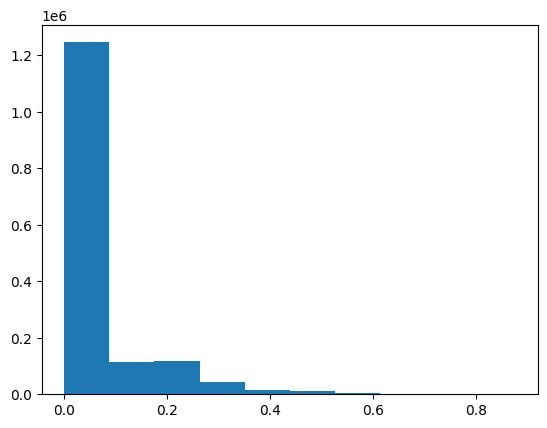

In [21]:
plt.hist(output_image.flatten().cpu().detach().numpy())

In [22]:
gt_image.shape

torch.Size([3, 540, 960])

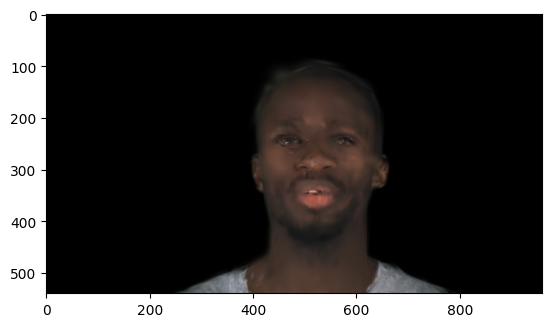

In [23]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # else imshow will crash kernel

import matplotlib.pyplot as plt


plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())

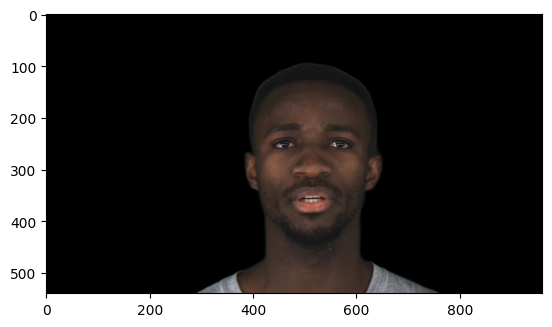

In [24]:
plt.imshow(gt_image.permute(1, 2, 0).cpu().detach().numpy())

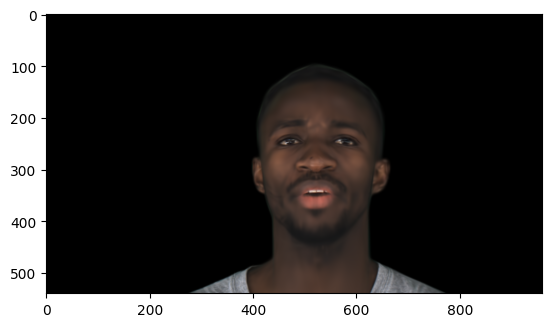

In [25]:
canon_image = render(front_cam[0],
                   gaussians, pipe, background, 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]

plt.imshow(canon_image.permute(1, 2, 0).cpu().detach().numpy())

In [30]:
l1_loss(gt_image, output_image)

tensor(0.0113, device='cuda:0')

In [31]:
gc.collect()

42

### Inference

In [2]:
test_vids = ['neutral_level_1_002']
'''
              'happy_level_2_005', 'happy_level_1_029',
       'happy_level_1_009', 'happy_level_1_028', 'happy_level_3_008',
       'neutral_level_1_024', 'neutral_level_1_026',
       'neutral_level_1_001', 'happy_level_2_002', 'happy_level_3_027',
       'neutral_level_1_023', 'neutral_level_1_016']
'''

test_indices = [v for v in data.videos if v in test_vids]
test_indices = [i for i, x in enumerate(data.videos) if x == test_vids[0]]
len(test_indices)

85

In [3]:
import gc
gc.collect()

42

In [4]:
test_split = Subset(data, test_indices)  
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE)

len(test_batches)

85

In [5]:
# load gaussians

from scene import GaussianModel, Scene
from gaussian_renderer import render
from arguments import PipelineParams, OptimizationParams
from arguments import ModelParams
from argparse import ArgumentParser
import sys
import torch

gpath = "C:/Users/arpit/Downloads/M005/M005"
colmap_path = "C:/Users/arpit/Desktop/gs_data/all_videos/M005"
sys.argv = f"x --source_path {colmap_path} -r 2".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])


temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

front_cam = [cam for cam in scene.getTrainCameras() if cam.image_name.startswith('front')]

pipe = PipelineParams(parser)

gaussians.load_ply("C:/Users/arpit/Desktop/M005_no_densify/point_cloud/iteration_30000/point_cloud.ply")

Reading camera 7/7
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  4085


In [6]:
gaussians._opacity.mean(), gaussians._xyz.mean(), gaussians._rotation.mean(), gaussians._scaling.mean()

(tensor(2.7384, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.4552, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2085, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-3.7944, device='cuda:0', grad_fn=<MeanBackward0>))

In [7]:
from deform_net import MLP
from utils.loss_utils import ssim
from utils.image_utils import psnr
import torch

model = MLP(n_gaussians=4085, n_features=11, aud_in=1707, emo_in=1280).to('cuda')
checkpoint = torch.load("C:/Users/arpit/Desktop/Model_40eps.pth")#, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MLP(
  (a_input): Linear(in_features=1707, out_features=500, bias=True)
  (e_input): Linear(in_features=1280, out_features=500, bias=True)
  (fc1): Linear(in_features=500, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=10000, bias=True)
  (fc3): Linear(in_features=10000, out_features=44935, bias=True)
  (relu): ReLU()
)

In [8]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 1920.336MB


In [9]:
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)

In [10]:
t_ssims = []
t_psnrs = []
t_images = []
t_l1s = []
t_lpips = []

from utils.loss_utils import l1_loss
from lpipsPyTorch import lpips
from gaussian_renderer import render_motion

with torch.no_grad():
        for batch_num, input_data in enumerate(test_batches):
            gt_image, aud, emo, _ = input_data
            gt_image = gt_image[0].to(device)
            aud = aud.to(device)
            emo = emo.to(device)            
            output = model(aud, emo)
            
            output_image = render_motion(front_cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(4085, -1), 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]
            
            t_images.append(output_image)
            ssim_value = ssim(output_image, gt_image)
            t_ssims.append(ssim_value.item())
            t_psnr = psnr(output_image, gt_image).mean().double()
            t_psnrs.append(t_psnr.item())
            t_l1s.append(l1_loss(output_image, gt_image).item())
            t_lpips.append(lpips(output_image, gt_image, net_type='vgg').item())

In [11]:
sum(t_l1s)/len(t_l1s)

0.0028390239595490344

In [12]:
sum(t_lpips)/len(t_lpips)

0.054159058849601184

In [13]:
sum(t_ssims)/len(t_ssims)

0.9813089728355407

In [14]:
sum(t_psnrs)/len(t_psnrs)

37.98180512820973

In [15]:
import gc
gc.collect()

170

In [16]:
t_images = [x.permute(1, 2, 0).cpu().detach().numpy() for x in t_images]

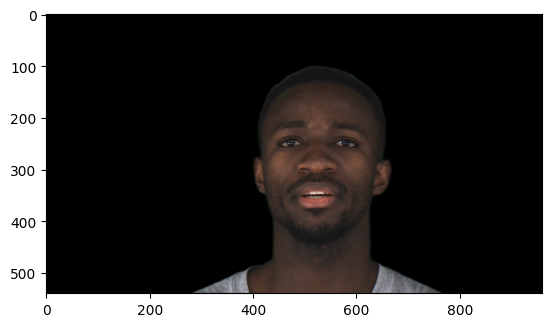

In [18]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # else imshow will crash kernel

import matplotlib.pyplot as plt


plt.imshow(gt_image.permute(1, 2, 0).cpu().detach().numpy())

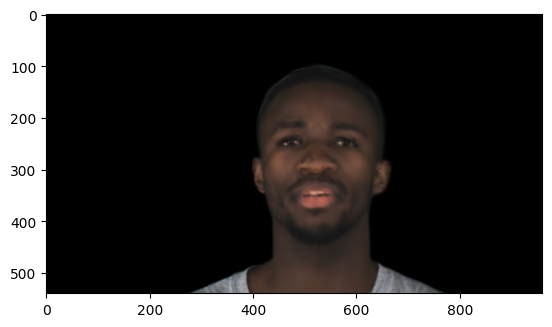

In [19]:
plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())

In [18]:
t_images[0].shape

(540, 960, 3)

In [19]:
from PIL import Image

i = 1

for im in t_images:
    tmp = Image.fromarray((im*255).astype(np.uint8))
    tmp.save(f"C:/Users/arpit/Desktop/neutral_002/{str(i)}.png")
    i += 1

In [20]:
import gc
gc.collect()

21

In [13]:
gt_image.dtype

torch.float32